In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LassoCV, RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import shap
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error, make_scorer

/Users/vivan/miniconda3/envs/DSO530/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import os

In [3]:
head, _ = os.path.split(os.getcwd())

In [5]:
df = pd.read_csv(os.path.join(head, '01_Data', 'cleaned_data.csv'), index_col=0)
# test_df = pd.read_csv('/content/drive/MyDrive/ML Project/cleaned_test_final.csv')

In [6]:
df['Loss_Cost'] = df['Loss_Cost'].fillna(0)
df['Historically_Adjusted_Loss_Cost'] = df['Historically_Adjusted_Loss_Cost'].fillna(0)

# STEP 4: Drop leakage and non-predictive columns
drop_cols = [
    'ID',
    'Start_Date_Contract', 'Date_Last_Renewal', 'Date_Next_Renewal',
    'Date_Of_Birth', 'Date_Of_DL_Issuance',
    'Loss_Cost', 'Historically_Adjusted_Loss_Cost', 'Claim_Status',
    'Total_Cost_Claims_Current_Yr', 'Total_Number_Claims_Current_Yr',
    'Total_Number_Claims_Entire_Duration', 'Ratio_Claims_Total_Duration_Force'
]

In [7]:
df.isna().sum()

ID                                       0
Start_Date_Contract                      0
Date_Last_Renewal                        0
Date_Next_Renewal                        0
Date_Of_Birth                            0
Date_Of_DL_Issuance                      0
Issurance_Broker_Agent_Channel           0
Years_Associates                         0
Total_Policies_Entity                    0
Max_Policy_Simultaneous_Force            0
Max_Product_Simultaneous_Held            0
Policies_Terminated_Non_Payment          0
Half_Yearly_Payment_Method               0
Premium_Amt_Current_Yr                   0
Total_Cost_Claims_Current_Yr             0
Total_Number_Claims_Current_Yr           0
Total_Number_Claims_Entire_Duration      0
Ratio_Claims_Total_Duration_Force        0
Motorbikes_Vans_Cars_Agricultural        0
Rural_Urban_Flag                         0
Multiple_Drivers_Regular_Flag            0
Yr_Vehicle_Registration                  0
Vehicle_Power_HP                         0
Cylinder_Ca

In [8]:
# prompt: change nan values in Energy_Source to 'N'

df['Energy_Source'] = df['Energy_Source'].fillna('N')


In [9]:
X_raw = df.drop(columns=drop_cols)
y_lc = df['Loss_Cost']
y_halc = df['Historically_Adjusted_Loss_Cost']

In [12]:
X_encoded = pd.get_dummies(X_raw, drop_first=True, dtype=int)

In [13]:
X_encoded

,Issurance_Broker_Agent_Channel,Years_Associates,Total_Policies_Entity,Max_Policy_Simultaneous_Force,Max_Product_Simultaneous_Held,Policies_Terminated_Non_Payment,Half_Yearly_Payment_Method,Premium_Amt_Current_Yr,Motorbikes_Vans_Cars_Agricultural,Rural_Urban_Flag,...,Young_Driver,Young_Bhp_Risk,Energy_Source_N,Energy_Source_P,Car_Age_Cat_Old,Car_Age_Cat_Recent,Car_Age_Cat_Standard,Car_Age_Contract_Cat_Old,Car_Age_Contract_Cat_Recent,Car_Age_Contract_Cat_Standard
0,0,1,1,1,1,1,0,573.07,3,0,...,1,0,0,1,1,0,0,1,0,0
1,0,3,1,1,1,0,0,299.19,3,0,...,1,0,0,0,0,0,1,0,0,1
2,1,20,2,2,1,0,0,257.66,3,0,...,0,0,0,1,1,0,0,0,0,0
3,0,8,2,3,1,0,0,288.70,3,0,...,0,0,0,0,0,0,1,0,1,0
4,0,9,1,1,1,0,0,741.16,3,0,...,0,0,0,1,1,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37446,1,1,1,1,1,0,0,402.66,2,0,...,0,0,0,0,0,0,1,0,0,1
37447,0,18,1,1,1,0,0,84.43,4,0,...,0,0,0,0,1,0,0,0,0,0
37448,0,3,1,1,1,0,0,254.92,3,1,...,1,0,0,1,1,0,0,1,0,0
37449,0,2,1,1,1,1,0,89.38,1,0,...,0,0,0,1,0,0,1,0,0,1


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Create quantile bins
y_lc_quantiles = pd.qcut(y_lc, q=4, labels=False, duplicates='drop')
y_halc_quantiles = pd.qcut(y_halc, q=4, labels=False, duplicates='drop')

# Combine them into a single stratification label
combined_bins = y_lc_quantiles * 4 + y_halc_quantiles

# Train-test split using combined quantile bins
# X_train, X_test, y_lc_train, y_lc_test, y_halc_train, y_halc_test = train_test_split(
#     X_encoded, y_lc, y_halc,
#     test_size=0.2,
#     random_state=42,
#     stratify=combined_bins
# )

In [17]:
from sklearn.model_selection import KFold
from interpret.glassbox import ExplainableBoostingRegressor

kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
feature_scores = pd.DataFrame(index=X_encoded.columns)

for fold, (train_idx, val_idx) in enumerate(kf.split(X_encoded, combined_bins)):
    X_fold_train = X_encoded.iloc[train_idx]
    y_fold = y_lc.iloc[train_idx]
    ebm = ExplainableBoostingRegressor(interactions=0, random_state=42, objective= 'tweedie_deviance:variance_power=1.5')
    ebm.fit(X_fold_train, y_fold)
    global_exp = ebm.explain_global()
    scores = pd.Series(global_exp.data()['scores'], index=X_encoded.columns, name=f"fold_{fold+1}")
    feature_scores = pd.concat([feature_scores, scores], axis=1)

/Users/vivan/miniconda3/envs/DSO530/lib/python3.11/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 128201 (\N{CHART WITH DOWNWARDS TREND}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


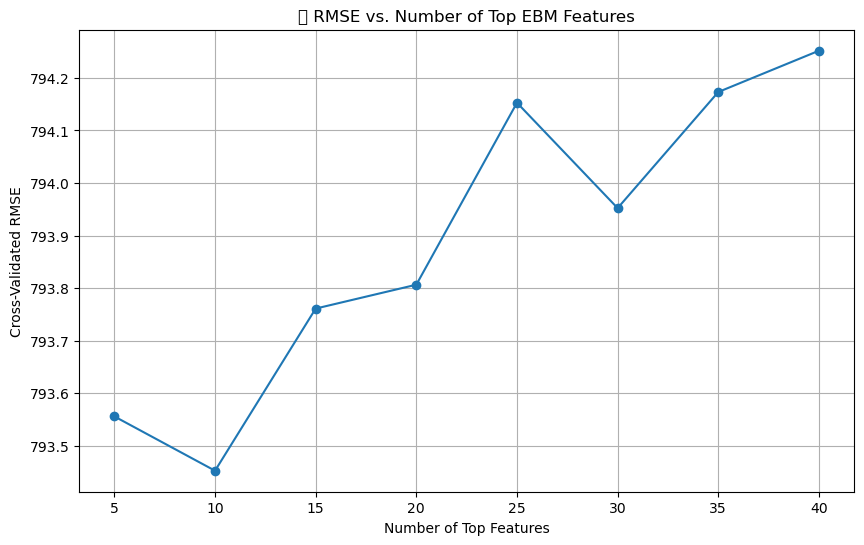

In [19]:
feature_scores['mean_importance'] = feature_scores.mean(axis=1)
sorted_scores = feature_scores['mean_importance'].sort_values(ascending=False)

# Evaluate RMSE for top-N features
rmse_list = []
feature_counts = list(range(5, 41, 5))
strat_kf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
for n in feature_counts:
    top_n_features = sorted_scores.head(n).index.tolist()
    ebm = ExplainableBoostingRegressor(interactions=0, random_state=42, objective= 'tweedie_deviance:variance_power=1.5')

    scores = cross_val_score(
        ebm,
        X_encoded[top_n_features],
        y_lc,
        scoring='neg_root_mean_squared_error',
        cv=strat_kf.split(X_encoded[top_n_features], combined_bins),
        n_jobs=-1
    )
    rmse_list.append(-scores.mean())

# Plot RMSE vs. number of top features
plt.figure(figsize=(10, 6))
plt.plot(feature_counts, rmse_list, marker='o')
plt.title("📉 RMSE vs. Number of Top EBM Features")
plt.xlabel("Number of Top Features")
plt.ylabel("Cross-Validated RMSE")
plt.grid(True)
plt.show()

In [20]:
top_features = feature_scores['mean_importance'].sort_values(ascending=False).head(15).index.tolist()
print(top_features)

['Non_Payment_Termination', 'Non_Continuation_Insurance_Flag', 'Contract_Duration', 'Time_Since_Last_Renewal', 'Premium_Amt_Current_Yr', 'Half_Yearly_Payment_Method', 'Age_at_license', 'Market_Value_EOY19', 'Policies_Terminated_Non_Payment', 'Ratio_Premium_Car_Value', 'Motorbikes_Vans_Cars_Agricultural', 'Vehicle_Wt_Kg', 'Max_Policy_Simultaneous_Force', 'Cylinder_Capacity', 'Total_Policies_Entity']


In [22]:
import optuna

In [24]:
from sklearn.metrics import mean_squared_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import KFold
X_selected = X_encoded[top_features]

In [27]:
import optuna
from sklearn.metrics import mean_squared_error
from interpret.glassbox import ExplainableBoostingRegressor
from sklearn.model_selection import KFold

X_selected = X_encoded[top_features]

def objective_lc(trial):
    params = {
        'interactions': trial.suggest_int('interactions', 0, 15),
        'max_bins': trial.suggest_categorical('max_bins', [128, 256, 512]),
        'max_leaves': trial.suggest_int('max_leaves', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_rounds': trial.suggest_int('max_rounds', 100, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'random_state': 64
    }
    tweedie_variance_power_1 = trial.suggest_float('tweedie_variance_power_1', 1, 2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]

        model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {tweedie_variance_power_1}',**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("\n🔍 Tuning EBM for Loss Cost...")
study_lc = optuna.create_study(direction='minimize')
study_lc.optimize(objective_lc, n_trials=50, timeout=10800)
print(f"✅ Best RMSE for LC: {study_lc.best_value:.2f}")
print("🎯 Best Params for LC:", study_lc.best_params)
param_stored = study_lc.best_params

[I 2025-04-26 07:44:51,985] A new study created in memory with name: no-name-e9cbdd07-d3c4-44b4-806a-68b4897f61f8



🔍 Tuning EBM for Loss Cost...


[I 2025-04-26 07:46:15,843] Trial 0 finished with value: 735.1813007672806 and parameters: {'interactions': 14, 'max_bins': 256, 'max_leaves': 3, 'learning_rate': 0.06744519405584574, 'max_rounds': 302, 'min_samples_leaf': 19, 'tweedie_variance_power_1': 1.1328241130926942}. Best is trial 0 with value: 735.1813007672806.
[I 2025-04-26 07:47:06,439] Trial 1 finished with value: 734.8757969613773 and parameters: {'interactions': 3, 'max_bins': 128, 'max_leaves': 2, 'learning_rate': 0.021722390062671907, 'max_rounds': 267, 'min_samples_leaf': 9, 'tweedie_variance_power_1': 1.2596772341908138}. Best is trial 1 with value: 734.8757969613773.
[I 2025-04-26 07:48:28,601] Trial 2 finished with value: 735.1129842076929 and parameters: {'interactions': 5, 'max_bins': 256, 'max_leaves': 3, 'learning_rate': 0.05454456200527093, 'max_rounds': 345, 'min_samples_leaf': 20, 'tweedie_variance_power_1': 1.1477199210703972}. Best is trial 1 with value: 734.8757969613773.
[I 2025-04-26 07:49:01,242] Trial

✅ Best RMSE for LC: 733.70
🎯 Best Params for LC: {'interactions': 7, 'max_bins': 512, 'max_leaves': 3, 'learning_rate': 0.005069392062695881, 'max_rounds': 123, 'min_samples_leaf': 5, 'tweedie_variance_power_1': 1.0639247427053524}


In [25]:
def objective_halc(trial):
    params = {
        'interactions': trial.suggest_int('interactions', 0, 15),
        'max_bins': trial.suggest_categorical('max_bins', [128, 256, 512]),
        'max_leaves': trial.suggest_int('max_leaves', 2, 6),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'max_rounds': trial.suggest_int('max_rounds', 100, 500),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 2, 20),
        'random_state': 42
    }
    tweedie_variance_power_2 = trial.suggest_float('tweedie_variance_power_1', 1, 2)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    for train_idx, val_idx in skf.split(X_selected, combined_bins):
        X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
        y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]
        model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {tweedie_variance_power_2}',**params)
        model = ExplainableBoostingRegressor(**params)
        model.fit(X_tr, y_tr)
        preds = model.predict(X_val)
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        scores.append(rmse)

    return np.mean(scores)

print("\n🔍 Tuning EBM for HALC...")
study_halc = optuna.create_study(direction='minimize')
study_halc.optimize(objective_halc, n_trials=50, timeout=10800)
print(f"✅ Best RMSE for HALC: {study_halc.best_value:.2f}")
print("🎯 Best Params for HALC:", study_halc.best_params)
param_stored2 = study_halc.best_params

[I 2025-04-26 07:35:05,559] A new study created in memory with name: no-name-29d4878b-4f03-48e0-9309-664710eaae35



🔍 Tuning EBM for HALC...


[I 2025-04-26 07:35:24,553] Trial 0 finished with value: 1467.7962581575478 and parameters: {'interactions': 15, 'max_bins': 512, 'max_leaves': 6, 'learning_rate': 0.015901559809938858, 'max_rounds': 338, 'min_samples_leaf': 15, 'tweedie_variance_power_1': 1.4131077116035096}. Best is trial 0 with value: 1467.7962581575478.
[I 2025-04-26 07:35:33,267] Trial 1 finished with value: 1466.9136236381953 and parameters: {'interactions': 12, 'max_bins': 256, 'max_leaves': 2, 'learning_rate': 0.04463600549516895, 'max_rounds': 158, 'min_samples_leaf': 18, 'tweedie_variance_power_1': 1.5626298526417948}. Best is trial 1 with value: 1466.9136236381953.
[I 2025-04-26 07:35:48,133] Trial 2 finished with value: 1467.717287967458 and parameters: {'interactions': 13, 'max_bins': 512, 'max_leaves': 5, 'learning_rate': 0.039398551354799805, 'max_rounds': 317, 'min_samples_leaf': 8, 'tweedie_variance_power_1': 1.272601846751792}. Best is trial 1 with value: 1466.9136236381953.
[I 2025-04-26 07:36:03,493

✅ Best RMSE for HALC: 1466.82
🎯 Best Params for HALC: {'interactions': 13, 'max_bins': 256, 'max_leaves': 2, 'learning_rate': 0.04729754794962393, 'max_rounds': 179, 'min_samples_leaf': 9, 'tweedie_variance_power_1': 1.3464931821726323}


NameError: name 'study_lc' is not defined

In [33]:
param_stored2 = study_halc.best_params

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train the final model on full training data (already done if model exists)
final_model_lc = ExplainableBoostingRegressor(**study_lc.best_params)
final_model_lc.fit(X_encoded[top_features], y_lc)

# Step 2: Explain globally (what features matter most + how they influence predictions)
global_exp = final_model_lc.explain_global()

print("📊 Global Feature Importances:")
for feature, score in zip(global_exp.data()['names'], global_exp.data()['scores']):
    print(f"{feature}: {score:.4f}")

# Launch interactive visual explanation dashboard
show(global_exp)

📊 Global Feature Importances:
Non_Payment_Termination: 13.9407
Non_Continuation_Insurance_Flag: 17.2498
Time_Since_Last_Renewal: 17.1109
Contract_Duration: 9.6490
Premium_Amt_Current_Yr: 8.5903
Half_Yearly_Payment_Method: 9.1862
Age_at_license: 7.0073
Policies_Terminated_Non_Payment: 10.4731
Market_Value_EOY19: 5.1748
Energy_Source_P: 1.3829
Car_Age_Contract_Cat_Standard: 3.6761
Vehicle_Wt_Kg: 5.8405
Issurance_Broker_Agent_Channel: 1.7415
Ratio_Premium_Car_Value: 2.4013
Years_Driving: 4.8859
Days_Driving_At_Start_Date: 3.7066
Cylinder_Capacity: 3.9939
Multiple_Drivers_Regular_Flag: 2.8147
Max_Policy_Simultaneous_Force: 1.9811
Car_Age_Cat_Old: 0.7657
Non_Payment_Termination & Non_Continuation_Insurance_Flag: 7.4607
Non_Payment_Termination & Time_Since_Last_Renewal: 7.3740
Non_Payment_Termination & Contract_Duration: 4.8522
Non_Continuation_Insurance_Flag & Contract_Duration: 4.7658
Non_Continuation_Insurance_Flag & Policies_Terminated_Non_Payment: 5.6969
Time_Since_Last_Renewal & Contra

In [ ]:
from interpret.glassbox import ExplainableBoostingRegressor
from interpret import show
from sklearn.metrics import mean_squared_error
import numpy as np

# Step 1: Train the final model on full training data for HALC
final_model_halc = ExplainableBoostingRegressor(**study_halc.best_params)
final_model_halc.fit(X_encoded[top_features], y_halc)

# Step 2: Explain globally
global_exp_halc = final_model_halc.explain_global()

print("📊 Global Feature Importances for HALC:")
for feature, score in zip(global_exp_halc.data()['names'], global_exp_halc.data()['scores']):
    print(f"{feature}: {score:.4f}")

# Launch interactive visual explanation dashboard
show(global_exp_halc)

📊 Global Feature Importances for HALC:
Non_Payment_Termination: 60.9001
Non_Continuation_Insurance_Flag: 72.5299
Time_Since_Last_Renewal: 28.4639
Contract_Duration: 59.3359
Premium_Amt_Current_Yr: 23.9176
Half_Yearly_Payment_Method: 19.1429
Age_at_license: 21.0343
Policies_Terminated_Non_Payment: 13.2962
Market_Value_EOY19: 12.8486
Energy_Source_P: 13.1932
Car_Age_Contract_Cat_Standard: 14.4446
Vehicle_Wt_Kg: 15.8700
Issurance_Broker_Agent_Channel: 8.7646
Ratio_Premium_Car_Value: 14.6376
Years_Driving: 16.2918
Days_Driving_At_Start_Date: 8.2320
Cylinder_Capacity: 12.1428
Multiple_Drivers_Regular_Flag: 3.5943
Max_Policy_Simultaneous_Force: 16.3652
Car_Age_Cat_Old: 6.2151
Non_Payment_Termination & Non_Continuation_Insurance_Flag: 18.9867
Non_Payment_Termination & Time_Since_Last_Renewal: 19.1417
Non_Payment_Termination & Contract_Duration: 5.2841
Non_Payment_Termination & Premium_Amt_Current_Yr: 17.9973
Non_Continuation_Insurance_Flag & Contract_Duration: 14.9747
Non_Continuation_Insuran

In [ ]:
df[df['Contract_Duration'] == df['Contract_Duration'].max()]

,Unnamed: 0,ID,Start_Date_Contract,Date_Last_Renewal,Date_Next_Renewal,Date_Of_Birth,Date_Of_DL_Issuance,Issurance_Broker_Agent_Channel,Years_Associates,Total_Policies_Entity,...,Customer_Loyalty,New_Bhp_Risk,Days_Driving_At_Start_Date,Age_at_license,Contract_Duration,Age_at_contract,Car_Age_Contract,Car_Age_Contract_Cat,Young_Driver,Young_Bhp_Risk
23800,23800,12566,1980-10-25,2018-10-25,2019-10-25,1951-09-25,1970-11-25,0,39,1,...,14.3,0,3622,7001,14244,29,11,Standard,0,0


In [40]:

from sklearn.metrics import mean_tweedie_deviance

tweedie_final_lc = param_stored.pop('tweedie_variance_power_1')



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
tweedie_scores = []
for train_idx, val_idx in skf.split(X_selected, combined_bins):
  X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
  y_tr, y_val = y_lc.iloc[train_idx], y_lc.iloc[val_idx]

  model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {tweedie_final_lc}',**param_stored)
  model.fit(X_tr, y_tr)
  preds = model.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, preds))
  tweedie_dev = mean_tweedie_deviance(y_val, preds, power=tweedie_final_lc)
  rmse_scores.append(rmse)
  tweedie_scores.append(tweedie_dev)

print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"Tweedie Deviance: {np.mean(tweedie_scores):.2f}")

RMSE: 734.89
Tweedie Deviance: 64.07


In [ ]:
tweedie_final_lc = param_stored['tweedie_variance_power_1']
param_stored.pop('tweedie_variance_power_1')

{'interactions': 6,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.007429403148954192,
 'max_rounds': 274,
 'min_samples_leaf': 12,
 'tweedie_variance_power_1': 1.38659404449943}

In [ ]:
param_stored = {'interactions': 6,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.007429403148954192,
 'max_rounds': 274,
 'min_samples_leaf': 12,
 'tweedie_variance_power_1': 1.38659404449943}

In [35]:

from sklearn.metrics import mean_tweedie_deviance

tweedie_final_halc = param_stored2.pop('tweedie_variance_power_1')



skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
rmse_scores = []
tweedie_scores = []
for train_idx, val_idx in skf.split(X_selected, combined_bins):
  X_tr, X_val = X_selected.iloc[train_idx], X_selected.iloc[val_idx]
  y_tr, y_val = y_halc.iloc[train_idx], y_halc.iloc[val_idx]

  model = ExplainableBoostingRegressor(objective=f'tweedie_deviance:variance_power = {tweedie_final_halc}',**param_stored2)
  model.fit(X_tr, y_tr)
  preds = model.predict(X_val)
  rmse = np.sqrt(mean_squared_error(y_val, preds))
  tweedie_dev = mean_tweedie_deviance(y_val, preds, power=tweedie_final_halc)
  rmse_scores.append(rmse)
  tweedie_scores.append(tweedie_dev)

print(f"RMSE: {np.mean(rmse_scores):.2f}")
print(f"Tweedie Deviance: {np.mean(tweedie_scores):.2f}")

RMSE: 1469.88
Tweedie Deviance: 107.50


In [34]:
param_stored2

{'interactions': 13,
 'max_bins': 256,
 'max_leaves': 2,
 'learning_rate': 0.04729754794962393,
 'max_rounds': 179,
 'min_samples_leaf': 9,
 'tweedie_variance_power_1': 1.3464931821726323}

In [32]:
param_stored

{'interactions': 7,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.005069392062695881,
 'max_rounds': 123,
 'min_samples_leaf': 5}

In [37]:
param_stored = study_lc.best_params

Best Params for HALC: {'interactions': 10, 'max_bins': 512, 'max_leaves': 5, 'learning_rate': 0.005410205107819921, 'max_rounds': 240, 'min_samples_leaf': 6}

In [39]:
param_stored = {'interactions': 6,
 'max_bins': 512,
 'max_leaves': 3,
 'learning_rate': 0.007429403148954192,
 'max_rounds': 274,
 'min_samples_leaf': 12,
 'tweedie_variance_power_1': 1.38659404449943}